<a href="https://colab.research.google.com/github/sreeja-g/wind_speed_forecasting/blob/master/wind_speed_seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install ewtpy

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
import gzip
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###Data

In [0]:
data = pd.read_csv("drive/My Drive/wind_data/data.txt", sep = ', ', header = None, engine='python')

In [0]:
data[:20]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
0,1949-01-01 00:00,WIND,310701,1,HWND6910,1,434,1001,170.0,15.0,NaN,NaN,NaN,9.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,","
1,1949-01-01 00:00,WIND,637801,1,HWND6910,1,970,1001,120.0,2.0,NaN,NaN,NaN,9.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,","
2,1949-01-01 00:00,WIND,737701,1,HWND6910,1,1135,1001,160.0,21.0,NaN,NaN,NaN,9.0,9.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,","
3,1949-01-01 00:00,WIND,914201,1,HWND6910,1,1450,1001,100.0,12.0,NaN,NaN,NaN,9.0,9.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,","
4,1949-01-01 00:00,WMO,3334,1,SYNOP,1,1135,1001,160.0,21.0,NaN,NaN,NaN,9.0,9.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,","
5,1949-01-01 01:00,WIND,310701,1,HWND6910,1,434,1001,170.0,13.0,NaN,NaN,NaN,9.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,","
6,1949-01-01 01:00,WIND,637801,1,HWND6910,1,970,1001,70.0,6.0,NaN,NaN,NaN,9.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,","
7,1949-01-01 01:00,WIND,737701,1,HWND6910,1,1135,1001,160.0,19.0,NaN,NaN,NaN,9.0,9.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,","
8,1949-01-01 01:00,WIND,914201,1,HWND6910,1,1450,1001,100.0,14.0,NaN,NaN,NaN,9.0,9.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,","
9,1949-01-01 01:00,WMO,3334,1,SYNOP,1,1135,1001,160.0,19.0,NaN,NaN,NaN,9.0,9.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,","


In [0]:
speed_data=pd.DataFrame(data[9].values,columns=['speed'])
speed_data.head()

,speed
0,15.0
1,2.0
2,21.0
3,12.0
4,21.0


In [0]:
speed_data.isna().sum()

speed    177
dtype: int64

In [0]:
speed_data=speed_data.fillna(speed_data.bfill())
speed_data.isna().sum()

speed    0
dtype: int64

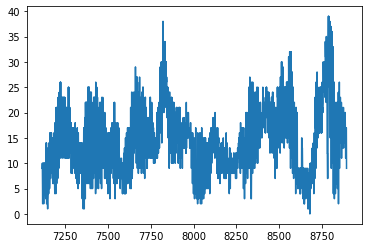

In [0]:
plt.plot(speed_data[int(len(speed_data)*0.8):])

###EWT

In [0]:
import ewtpy

In [0]:
ewt,  mfb ,boundaries = ewtpy.EWT1D(speed_data['speed'], N = 30)
ewt=ewt.transpose()

data_all=[]
for i in range(len(ewt)):
  wavelet=ewt[i]
  wavelet=np.array(wavelet)
  wavelet=np.reshape(wavelet, (-1, 1))
  data_all.append(wavelet)

data_all[0].shape

(8894, 1)

###ELM

In [0]:
class Elm:

  def __init__(self):
    self.weights = None
    self.bias = None
    self.beta = None


  def fit(self,X_train,y_train):
    self.n_value = len(X_train[0])
    self.m_value = len(y_train[0])
    self.l_value = int((2/3)*(self.n_value+self.m_value))
    self.weights = 2*np.random.random((self.n_value,self.l_value)) - 1
    self.bias = 2*np.random.random((self.l_value)) - 1

    H=self.get_H_matrix(X_train)
    self.beta=np.matmul(np.linalg.pinv(H),y_train)


  def predict(self,X_test):
    H=self.get_H_matrix(X_test)
    return np.matmul(H,self.beta)


  def get_H_matrix(self,x):
    H = np.empty((0,self.l_value))
    for i in range(len(x)):
      f_x,g_x=0,0
      f_x=np.matmul(x[i],self.weights)+self.bias 
      g_x=self.sigmoid(f_x) 
      H=np.append(H,[g_x],axis=0)
    return H


  def sigmoid(self,value):
    return 1/(1 + np.exp(-value))




In [0]:
def make_lag_data(x_data,n_value,m_value):
  X = []
  y = []
  for i in range(n_value, len(x_data)-m_value+1):
    X.append(x_data[(i-n_value):(i)])
    y.append(x_data[i:i+m_value])
  X=np.array(X)
  X=X.reshape(X.shape[0],X.shape[1])
  y=np.array(y)
  y=y.reshape(y.shape[0],y.shape[1])
  return (X,y)

In [0]:
from sklearn.metrics import mean_squared_error,mean_absolute_error

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

wavelet-0
mse:  0.1594930298168365
mae:  0.30001022027349145
mape:  1.9334100793212343


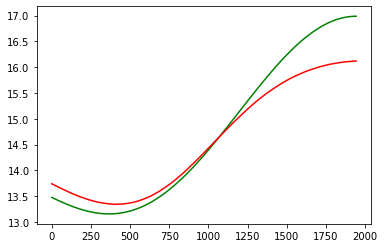

wavelet-1
mse:  0.001445064764458227
mae:  0.028064877649104147
mape:  3.726227332757596


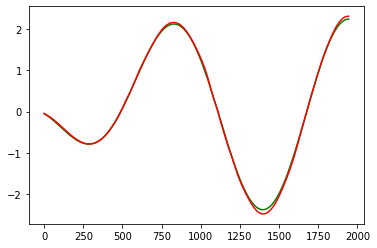

wavelet-2
mse:  1.2698316598478666e-05
mae:  0.002934048330942896
mape:  1.3432749701106699


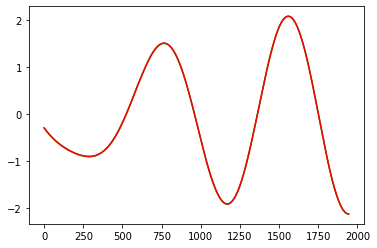

wavelet-3
mse:  2.579148251140694e-08
mae:  0.00012004367547384266
mape:  0.16881802491888978


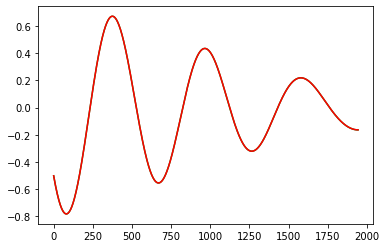

wavelet-4
mse:  0.0597685642004346
mae:  0.17600546112467083
mape:  11.353273204301653


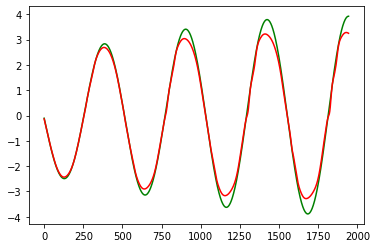

wavelet-5
mse:  0.00028065661917338976
mae:  0.014687039026358028
mape:  5.16340432998972


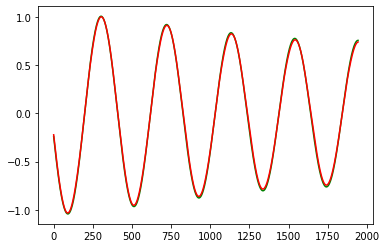

wavelet-6
mse:  4.696942441640944e-06
mae:  0.0017528115188261482
mape:  15.458058354359782


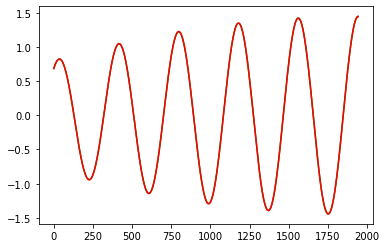

wavelet-7
mse:  3.6498624067360934e-05
mae:  0.004698785804611664
mape:  19.18366373913502


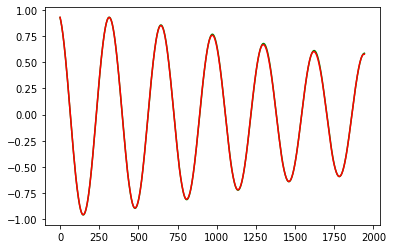

wavelet-8
mse:  0.0029126340950605704
mae:  0.043155611642909514
mape:  287.38880218604066


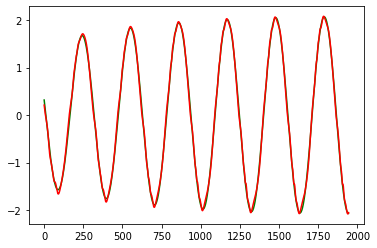

wavelet-9
mse:  4.9127261442905796e-05
mae:  0.0054204692404793
mape:  11.166570646795378


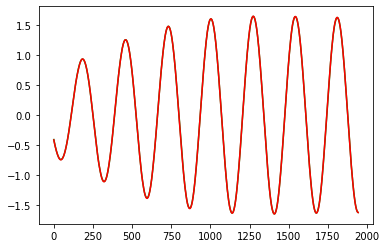

wavelet-10
mse:  0.10783977810277799
mae:  0.18677905701469946
mape:  17.13372613699416


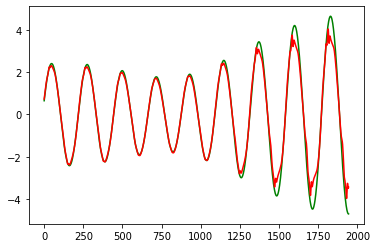

wavelet-11
mse:  0.0016632131346450679
mae:  0.03323923758845094
mape:  11.075540379214486


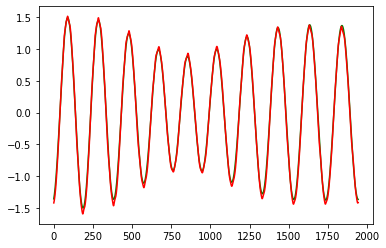

wavelet-12
mse:  7.558457435861991e-05
mae:  0.006837695377621976
mape:  6.450877206895401


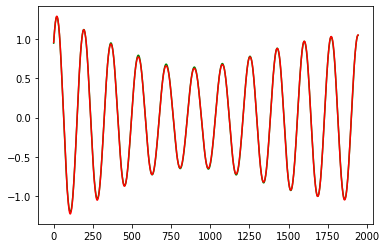

wavelet-13
mse:  1.724092329377875e-06
mae:  0.0009527039944148816
mape:  3.329595377806464


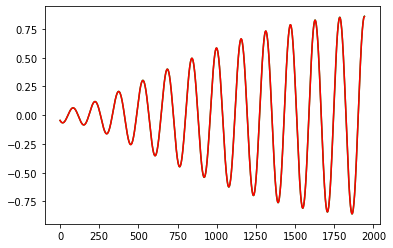

wavelet-14
mse:  0.0027043386502523903
mae:  0.04183807343643801
mape:  6.914008638165208


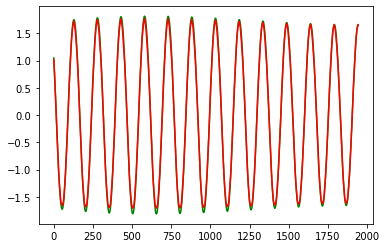

wavelet-15
mse:  2.1694546068731726
mae:  1.032828027840056
mape:  343.45369772438755


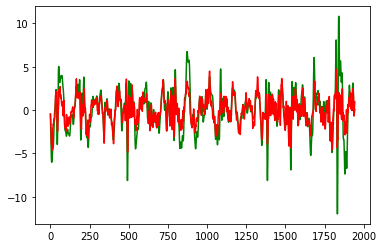

wavelet-16
mse:  1.231602968432503
mae:  0.8082095641858377
mape:  268.02089128532765


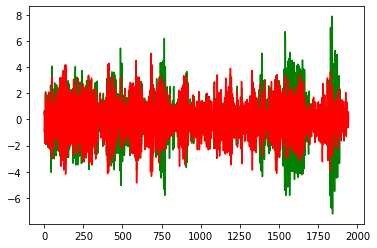

wavelet-17
mse:  0.24565003919923178
mae:  0.3969457720493789
mape:  468.88706962161075


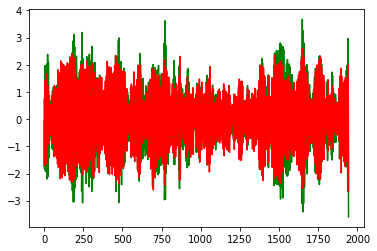

wavelet-18
mse:  0.41158802215357265
mae:  0.4828462144876659
mape:  194.09858742152574


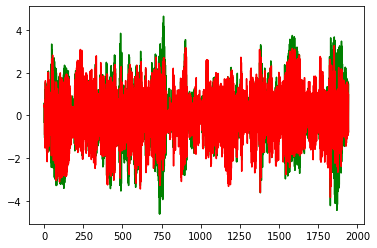

wavelet-19
mse:  0.32483431250637673
mae:  0.43970202234002875
mape:  359.2147212825933


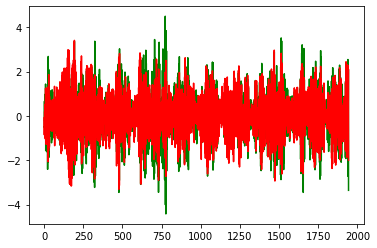

wavelet-20
mse:  1.3504617412093713
mae:  0.8803401911883232
mape:  150.7044351041708


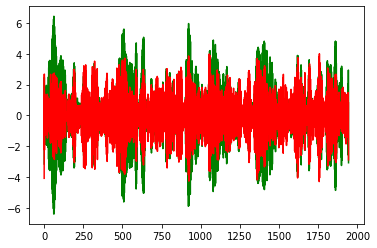

wavelet-21
mse:  0.00023148190642786515
mae:  0.011428472552706457
mape:  16.989425463859554


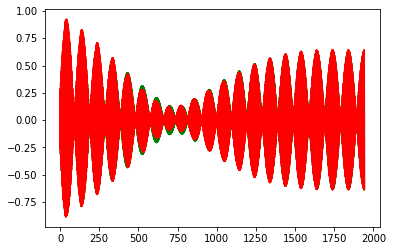

wavelet-22
mse:  0.008223795299174878
mae:  0.059909206758923986
mape:  12.255387855578062


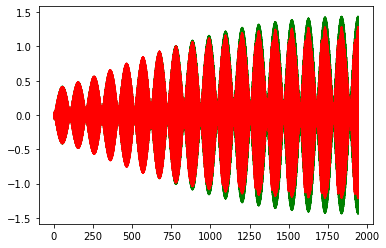

wavelet-23
mse:  2.1030222630413824e-07
mae:  0.0003862388099825344
mape:  0.6831495506252709


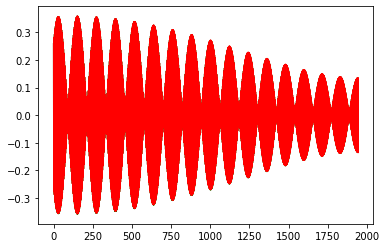

wavelet-24
mse:  2.4277719411316273e-06
mae:  0.0012403674815225718
mape:  316.6829366257892


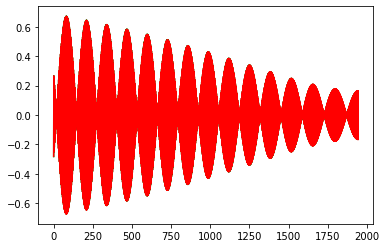

wavelet-25
mse:  1.9256014979120466e-06
mae:  0.0011043483029496304
mape:  0.6463466915652267


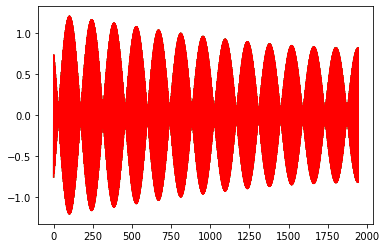

wavelet-26
mse:  2.516813553425591e-05
mae:  0.004082544901253603
mape:  1.6625605126562102


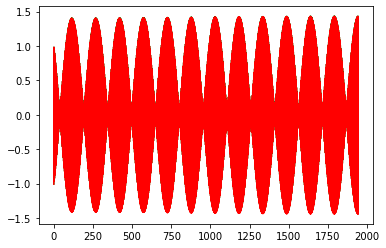

wavelet-27
mse:  4.157205143566494e-05
mae:  0.005398908825681385
mape:  5.237448589809059


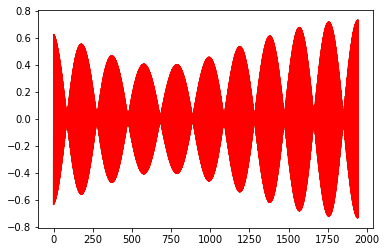

wavelet-28
mse:  0.0002199247349178059
mae:  0.012520897533488382
mape:  10.650482941702535


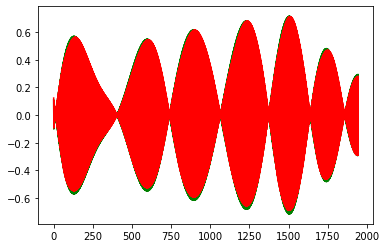

wavelet-29
mse:  0.0035335684415997264
mae:  0.01961391275766895
mape:  1.1240676180905178


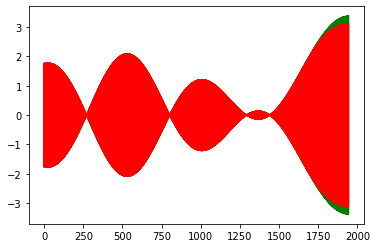

In [0]:
y_test_collected=[]
y_pred_collected=[]

for i in range(len(data_all)):
  
  wavelet=data_all[i]

  input_values=60
  output_values=1

  (X,y)=make_lag_data(wavelet,input_values,output_values)

  X_train = X[:int(len(X)*0.78)]
  y_train = y[:int(len(y)*0.78)]

  X_test = X[int(len(X)*0.78):]
  y_test = y[int(len(y)*0.78):]

  model=Elm()
  model.fit(X_train,y_train)
  y_pred = model.predict(X_test)

  print("wavelet-"+str(i))
  print("mse: ",mean_squared_error(y_test,y_pred))
  print("mae: ",mean_absolute_error(y_test,y_pred))
  print("mape: ",mean_absolute_percentage_error(y_test,y_pred))

  y_test_collected.append(y_test)
  y_pred_collected.append(y_pred)

  plt.plot(y_test,color='green')
  plt.plot(y_pred,color='red')
  plt.show()

test data
mse:  6.1697143619039405
mae:  1.8581725788406827
mape:  25.005870239508727


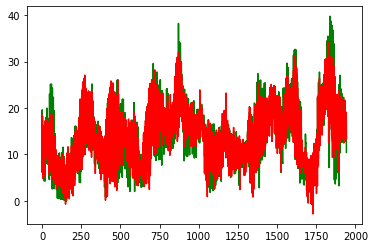

In [0]:
y_test_all=np.sum(y_test_collected,axis=0)
y_pred_all=np.sum(y_pred_collected,axis=0)

print("test data")
print("mse: ",mean_squared_error(y_test_all,y_pred_all))
print("mae: ",mean_absolute_error(y_test_all,y_pred_all))
print("mape: ",mean_absolute_percentage_error(y_test_all,y_pred_all))

plt.plot(y_test_all,color='green')
plt.plot(y_pred_all,color='red')
plt.show()

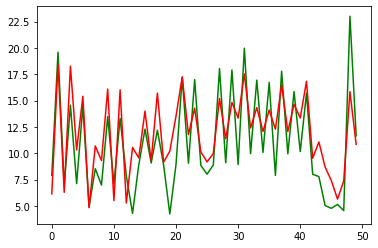

In [0]:
plt.plot(y_test_all[:50],color='green')
plt.plot(y_pred_all[:50],color='red')
plt.show()